# Optimal Control: Taylor-Green Flow

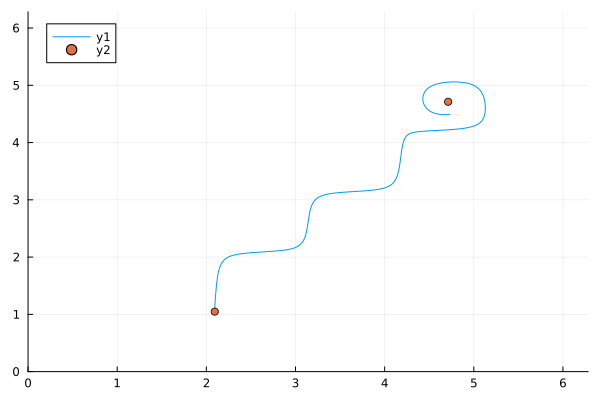

In [1]:
using OrdinaryDiffEq,
      Optimization, OptimizationPolyalgorithms, SciMLSensitivity,
      Zygote, Plots

function advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*sin(3*x)*cos(3*y) + 0.1*T*cos(z)
    du[2] = dy = -T*cos(3*x)*sin(3*y) + 0.1*T*sin(z)
    du[3] = dz = 3*T*(sin(3*x)*sin(3*y)+cos(3*x)*cos(3*y)*sin(2*z))
end

# Initial condition
xA = 2*pi/3
yA = pi/3

# Desired end point 
xB = 3*pi/2
yB = 3*pi/2

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

# System parameters (initial guess)
p = [1.5608, 10.0]

u0 = [xA, yA, p[1]]

# Setup the ODE problem, then solve
prob = ODEProblem(advection!, u0, tspan, p)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

# Plot the solution
using Plots
plot(t->sol(t)[1], t->sol(t)[2], 0, 1, xlim=(0, 2*pi), ylim=(0, 2*pi))
scatter!([xA, xB], [yA, yB])

In [2]:
# Loss function to be minimized
function loss(p)
    prob = ODEProblem(advection!, [xA, yA, p[1]], tspan, p)
    sol = solve(prob, Tsit5(), p = p, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)
    loss = (sol[end][1]-xB)^2 + (sol[end][2]-yB)^2
    return loss
end

# display value of loss during optimization
callback = function (state, l)
    if (state.iter % 100) == 0
        println("loss=", l)
    end
    return false
end

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p)

result_ode = Optimization.solve(optprob, PolyOpt(),
    callback = callback, reltol = 1e-8, abstol = 1e-8,
    maxiters = 1000)

loss=10.924631173937627
loss=10.827118474692332
loss=10.826610852417518
loss=10.825966924905424
loss=10.825171423194226
loss=10.824202327380664
loss=10.82302702190239
loss=10.821599085097638
loss=10.81985246997785
loss=10.817691512505057
loss=0.047895349063143626
loss=0.047895349063143626


retcode: Success
u: 2-element Vector{Float64}:
  1.5607888077227354
 12.203803232024974

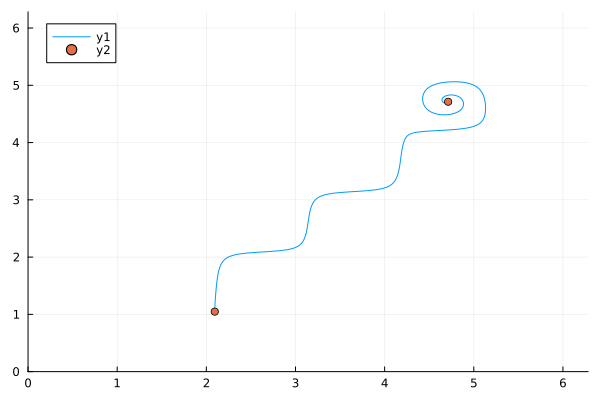

In [3]:
# optimal control solution:
p_opt = result_ode.u
prob_opt = ODEProblem(advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

plot(t->opt_solution(t)[1], t->opt_solution(t)[2], 0, 1, xlim=(0, 2*pi), ylim=(0, 2*pi))
scatter!([xA, xB], [yA, yB])

### Optimal Trajectory + Perturbations (Noise)

In [4]:
# generating trajectories with noisy initial control
ϵ = (pi/180)/50

p1 = [result_ode.u[1]+ϵ, result_ode.u[2]]
prob_p1 = ODEProblem(advection!, [xA, yA, p1[1]], tspan, p1)
p1_solution = solve(prob_p1, Tsit5(), p = p1, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

p2 = [result_ode.u[1]-ϵ, result_ode.u[2]]
prob_p2 = ODEProblem(advection!, [xA, yA, p2[1]], tspan, p2)
p2_solution = solve(prob_p2, Tsit5(), p = p2, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

# generating trajectories with noisy start position
Δ = 1e-3

prob_p3 = ODEProblem(advection!, [xA+Δ, yA, p_opt[1]], tspan, p_opt)
p3_solution = solve(prob_p3, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

prob_p4 = ODEProblem(advection!, [xA, yA+Δ, p_opt[1]], tspan, p_opt)
p4_solution = solve(prob_p4, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

nothing

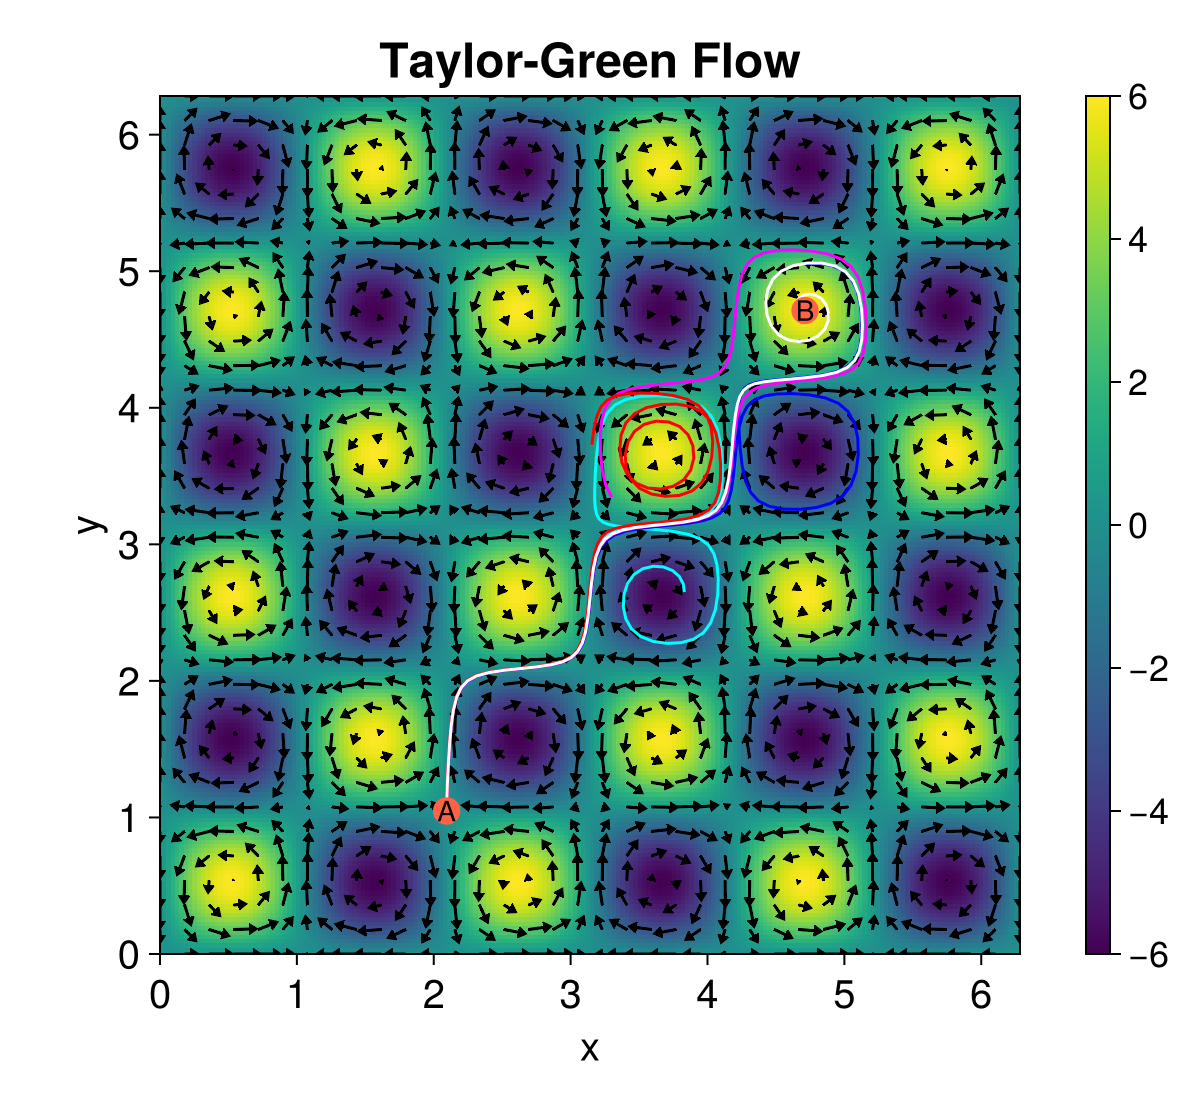

In [5]:
using CairoMakie

u(x,y) = sin(3*x)*cos(3*y)
v(x,y) = -cos(3*x)*sin(3*y)
vort(x,y) = 6*sin(3*x)*sin(3*y)

xs = range(0, 2*pi, length=200)
ys = range(0, 2*pi, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(0, 2*pi, 36)
ys2 = LinRange(0, 2*pi, 36)
us2 = [u(x,y) for x in xs2, y in ys2]
vs2 = [v(x,y) for x in xs2, y in ys2]

times = range(0, 1, length=100)
x_track = [opt_solution(t)[1] for t in times]
y_track = [opt_solution(t)[2] for t in times]

x1_track = [p1_solution(t)[1] for t in times]
y1_track = [p1_solution(t)[2] for t in times]

x2_track = [p2_solution(t)[1] for t in times]
y2_track = [p2_solution(t)[2] for t in times]

x3_track = [p3_solution(t)[1] for t in times]
y3_track = [p3_solution(t)[2] for t in times]

x4_track = [p4_solution(t)[1] for t in times]
y4_track = [p4_solution(t)[2] for t in times]

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1], title = "Taylor-Green Flow", titlesize = 24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 2*pi), (0, 2*pi))
)

hm = CairoMakie.heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-6, 6))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.2, tiplength=4, tipwidth=6,
            shaftwidth=1.5, minshaftlength=0)

lines!(ax, x1_track, y1_track, color=:cyan)
lines!(ax, x2_track, y2_track, color=:blue)
lines!(ax, x3_track, y3_track, color=:magenta)
lines!(ax, x4_track, y4_track, color=:red)
lines!(ax, x_track, y_track, color=:white)

poly!(ax, Circle(Point2f(xA, yA), 0.1), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), 0.1), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))

save("Taylor-Green.pdf", fig)
fig

# Lyapunov Exponent

In [2]:
dS = [1e-7, 1e-7, 1e-7]  #[dx,dy,dθ]

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p_opt = [1.5607888077227354, 12.203803232024974]
prob_opt = ODEProblem(advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

# perturbed solutions
prob_S1 = ODEProblem(advection!, [xA+dS[1], yA, p_opt[1]], tspan, p_opt)
pS1_solution = solve(prob_S1, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

prob_S2 = ODEProblem(advection!, [xA, yA+dS[2], p_opt[1]], tspan, p_opt)
pS2_solution = solve(prob_S2, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

p_dS = [p_opt[1]+dS[3], p_opt[2]]
prob_S3 = ODEProblem(advection!, [xA, yA, p_dS[1]], tspan, p_dS)
pS3_solution = solve(prob_S3, Tsit5(), p = p_dS, saveat = tsteps, reltol = 1e-8, abstol = 1e-8)

nothing

In [6]:
times = range(0, 1, length=100)
T = p_opt[2]

# construction of matrix W from perturbed solutions
W11 = [(pS1_solution(t)[1] - opt_solution(t)[1])/dS[1] for t in times]
W21 = [(pS1_solution(t)[2] - opt_solution(t)[2])/dS[1] for t in times]
W31 = [(pS1_solution(t)[3] - opt_solution(t)[3])/dS[1] for t in times]

W12 = [(pS2_solution(t)[1] - opt_solution(t)[1])/dS[2] for t in times]
W22 = [(pS2_solution(t)[2] - opt_solution(t)[2])/dS[2] for t in times]
W32 = [(pS2_solution(t)[3] - opt_solution(t)[3])/dS[2] for t in times]

W13 = [(pS3_solution(t)[1] - opt_solution(t)[1])/dS[3] for t in times]
W23 = [(pS3_solution(t)[2] - opt_solution(t)[2])/dS[3] for t in times]
W33 = [(pS3_solution(t)[3] - opt_solution(t)[3])/dS[3] for t in times]

nothing

In [7]:
using LinearAlgebra

l1 = zeros(100)
l2 = zeros(100)
l3 = zeros(100)

# calculation of Lyapunov exponents 
for i in 1:100
    W = [W11[i] W12[i] W13[i]; W21[i] W22[i] W23[i]; W31[i] W32[i] W33[i]]
    l1[i], l2[i], l3[i] = log.(svdvals(W))/(times[i])
end

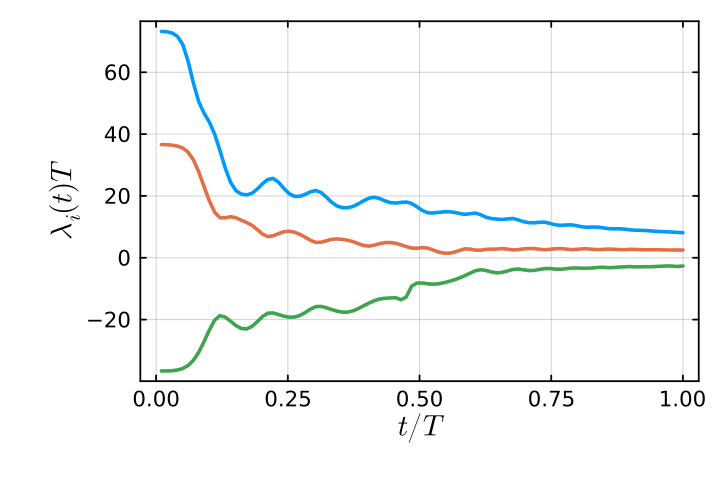

In [8]:
using LaTeXStrings

p = plot(times, [l1, l2, l3], framestyle=:box, lw=2, xlabel=L"t/T", ylabel=L"\lambda_i(t)T",
    legend=false, dpi=120, thickness_scaling=1.5)

savefig(p, "Taylor-Green FTLE.pdf")
p